# Generate surrogate data

The function generate_mock_data produces surrogate data with different firing rate and where all neurons have the same simple dynamics of a sawtooth pattern.

In [2]:
import torch
import numpy as np
from scipy import signal

def generate_mock_data(N_V, T, sampling_frequency=4, average_firing_rate=0.0213, stimulus_period=480/4, random_seed=0):
    ''' Generate spike train data of N_V neurons for T timesteps with a given sampling frequency (Hz) and avarage firing rate.
        Stimulus period is taken from Misha's data.
        Returns spike trains and time array. '''
    
    # set random seed
    torch.random.manual_seed(random_seed)
    
    # calculate stimulus frequency
    stimulus_frequency = 1 / stimulus_period

    # create time array
    time_arr = torch.linspace(0, T/sampling_frequency, T)
    
    # calculate firing probability with triangle wave
    firing_probability = torch.tensor(average_firing_rate * (signal.sawtooth(2 * np.pi * stimulus_frequency * time_arr, 0.5) + 1))

    # spike trains
    spikes = torch.rand(N_V, T) < firing_probability.expand(N_V, T)
    spikes = spikes.type(torch.DoubleTensor)
    
    return spikes, time_arr

In [3]:
spikes, time_arr = generate_mock_data(1024, 2880)

Spiking pattern

<AxesSubplot:>

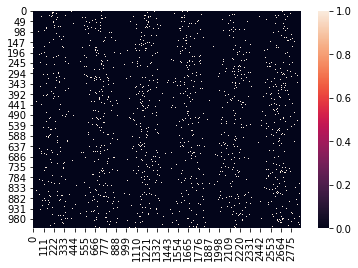

In [4]:
import seaborn as sns
sns.heatmap(spikes)

Test average firing rate (should be close to 0.0213)

In [5]:
torch.mean(spikes)

tensor(0.0215, dtype=torch.float64)

Same mean but different distibution.
The data shows a logaritmic distribution over the mean firing rate and the amount of neurons with that firing rate in contrast to the surrogate data.

Text(0.5, 1.0, 'True data')

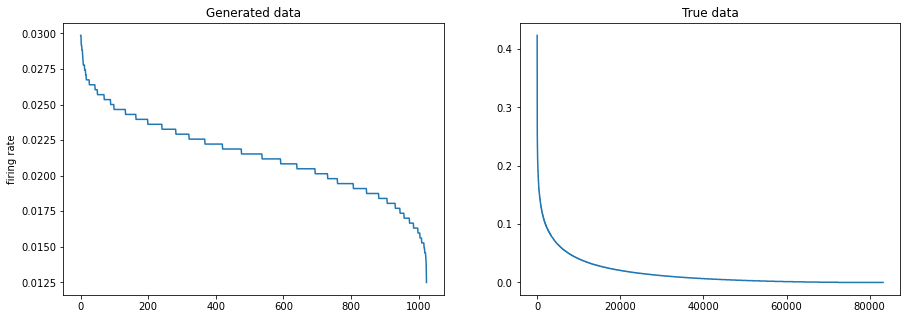

In [28]:
import matplotlib.pyplot as plt
from loaddata import *



spikes_true,_,_,_,_ = load_data()
spike_thres = 0.15

spikes_true[spikes_true>spike_thres] = 1
spikes_true[spikes_true<spike_thres] = 0

spikes_true = np.array(spikes_true.T)


    
spikes = np.array(spikes)
f_rate_order1 = np.argsort(np.sum(spikes,1))[::-1] #reverse order
spikes_gen = spikes[f_rate_order1, :]
spikes_gen = torch.tensor(spikes_gen)

spikes_true = np.array(spikes_true)
f_rate_order_true = np.argsort(np.sum(spikes_true,1))[::-1] #reverse order
spikes_true = spikes_true[f_rate_order_true, :]
spikes_true = torch.tensor(spikes_true)

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(torch.mean(spikes_gen,1))
axs[0].set_title('Generated data')
axs[0].set_ylabel('firing rate')
axs[1].plot(torch.mean(spikes_true,1))
axs[1].set_title('True data')

Because we want to have the same kind of distribution we discritize the true distribution in nr_of_discretized_steps steps each with a different mean firing rate. This will allow us reproduce the firing rate distribution of the data with a pre-chosen amount of neurons.

In [29]:
nr_of_discretized_steps = 1000
mean_firing_rate_discretized = torch.zeros(nr_of_discretized_steps)
for i in range(0,nr_of_discretized_steps-1):
    idx = int(np.round(spikes.shape[0]/nr_of_discretized_steps))
    mean_firing_rate_discretized[i] = torch.mean(spikes_true[i*idx:(i+1)*idx,:])

In [34]:
def generate_mock_data(N_V, T, sampling_frequency=4, average_firing_rate=0.0213, stimulus_period=480/4, random_seed=0):
    ''' Generate spike train data of N_V neurons for T timesteps with a given sampling frequency (Hz) and avarage firing rate.
        Stimulus period is taken from Misha's data.
        Returns spike trains and time array. '''
    
    # set random seed
    torch.random.manual_seed(random_seed)
    
    # calculate stimulus frequency
    stimulus_frequency = 1 / stimulus_period

    # create time array
    time_arr = torch.linspace(0, T/sampling_frequency, T)
    
    # calculate firing probability with triangle wave
    firing_probability = torch.tensor(average_firing_rate * (signal.sawtooth(2 * np.pi * stimulus_frequency * time_arr, 0.5) + 1))

    # spike trains
    spikes = torch.rand(N_V, T) < firing_probability.expand(N_V, T)
    spikes = spikes.type(torch.FloatTensor)
    
    return spikes, time_arr

In [68]:
data = generate_data_fr_dist(N_V, T, spikes_true, randperm=False)

<ipython-input-34-17b8ba50f215>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  firing_probability = torch.tensor(average_firing_rate * (signal.sawtooth(2 * np.pi * stimulus_frequency * time_arr, 0.5) + 1))


Text(0.5, 1.0, 'New generated data')

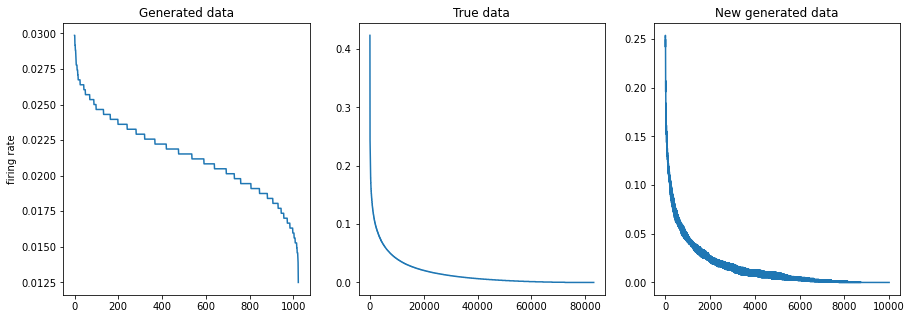

In [69]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(torch.mean(spikes_gen,1))
axs[0].set_title('Generated data')
axs[0].set_ylabel('firing rate')
axs[1].plot(torch.mean(spikes_true,1))
axs[1].set_title('True data')
axs[2].plot(torch.mean(data,1))
axs[2].set_title('New generated data')

Next, we want to train a RTRBM on the surrogate data

In [79]:
from RTRBM.RTRBM_batches import RTRBM
from data.manipulate_data import *

In [90]:
N_V = 100
T = 300
data = generate_data_fr_dist(N_V, T, spikes_true, nr_of_discretized_steps=10, randperm=False)

In [87]:
rtrbm = RTRBM(data)

<AxesSubplot:>

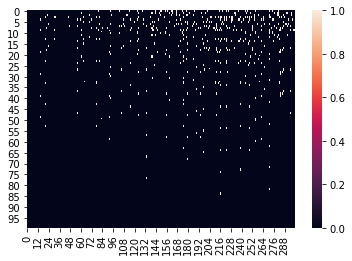

In [91]:
sns.heatmap(data)

In [89]:
N_H = 100
rtrbm.learn(N_H,
            mean_field = 'False',
            spars_penalty = 3e-5, x = 2, sp = True,
            activationFunction = torch.sigmoid,
            learning_rate = 0.01,  learning_rate_decay = True,
            momentum = 0.9, 
            weightcost = 0.0002, 
            CDk = 10, 
            maxepoch = 1000, 
            batchsize = 128,
            disable_tqdm = False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:35<00:00,  2.20it/s]


In [67]:
T = 3000
N_V = 10000

def generate_data_fr_dist(N_V, T, spikes_true, nr_of_discretized_steps=1000, randperm=True):
    ''' This function creates mock data, but with the right firing rate distribution as given by spikes_true data. '''

    # sort the spikes according to firing rate
    f_rate_order_true = torch.argsort(torch.sum(spikes_true,1), descending=True)
    spikes_true = spikes_true[f_rate_order_true, :]
    
    # create empty data tensor
    data = torch.zeros(N_V,T)
    
    # loop over number of discretized steps
    for i in range(0,nr_of_discretized_steps):
        
        # an indexer
        idx = int(spikes_true.shape[0]/nr_of_discretized_steps)
        
        # calculate mean firing rate of spikes_true batch
        mean_firing_rate_discretized = torch.mean(spikes_true[i*idx:(i+1)*idx,:])
        
        # use mean firing rate to generate mock data
        data[int(i*N_V/nr_of_discretized_steps):int((i+1)*N_V/nr_of_discretized_steps),:], time_arr = \
        generate_mock_data(int(N_V/nr_of_discretized_steps), T, average_firing_rate=mean_firing_rate_discretized)

    # randomly permute data
    if randperm == True:
        data = data[torch.randperm(data.shape[0]), :]
        
    return data

In [3]:
plt.plot(rtrbm.errors) # Die error kan niet zo klein zijn

NameError: name 'rtrbm' is not defined

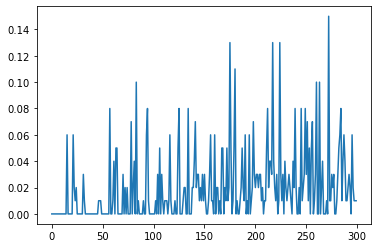

In [94]:
plt.plot(torch.mean(data,0))

In [95]:
data, time_arr = generate_mock_data(N_V, T, sampling_frequency=4, average_firing_rate=0.2, stimulus_period=10)

<AxesSubplot:>

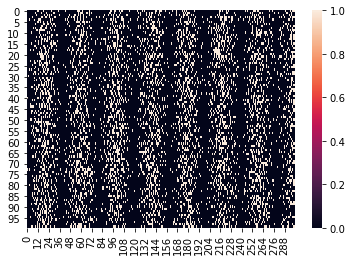

In [97]:
sns.heatmap(data)

In [96]:
rtrbm2 = RTRBM(data)

In [98]:
N_H = 10
rtrbm2.learn(N_H,
            mean_field = 'False',
            spars_penalty = 3e-5, x = 2, sp = True,
            activationFunction = torch.sigmoid,
            learning_rate = 0.01,  learning_rate_decay = True,
            momentum = 0.9, 
            weightcost = 0.0002, 
            CDk = 10, 
            maxepoch = 200, 
            batchsize = 128,
            disable_tqdm = False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.35it/s]


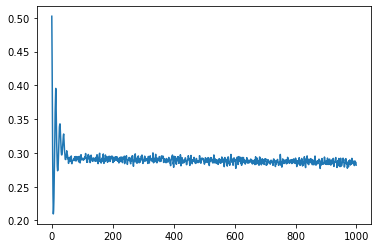

In [100]:
plt.plot(rtrbm2.errors) # Die error kan niet zo klein zijn

In [113]:
V_est, H_est = rtrbm2.infer(data,
                            activationFunction = torch.sigmoid,
                            pre_gibbs_k = 1,
                            gibbs_k = 10,
                            mode = 2,
                            t_extra = 300)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 337.24it/s]


<AxesSubplot:>

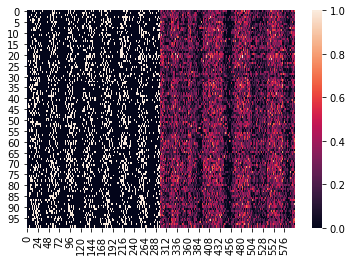

In [114]:
sns.heatmap(V_est)

In [1]:
from data.manipulate_data import *
from loaddata import *

In [2]:
spikes_true,_,_,_,_ = load_data()

spike_thres = 0.15
spikes_true[spikes_true>spike_thres] = 1
spikes_true[spikes_true<spike_thres] = 0
spikes_true = torch.tensor(spikes_true)

V_gen = generate_data_fr_dist(1000, 3000, spikes_true, nr_of_discretized_steps=100)

C:\Users\CP\OneDrive\RU\Intern\Master\data\manipulate_data.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  firing_probability = torch.tensor(average_firing_rate * (signal.sawtooth(2 * np.pi * stimulus_frequency * time_arr, 0.5) + 1))


<AxesSubplot:>

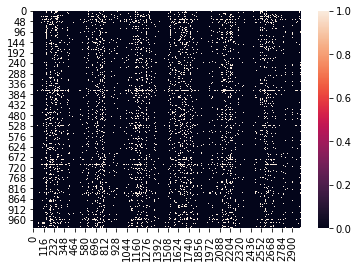

In [3]:
import seaborn as sns

sns.heatmap(V_gen)

In [4]:
V_gen.shape

torch.Size([1000, 3000])

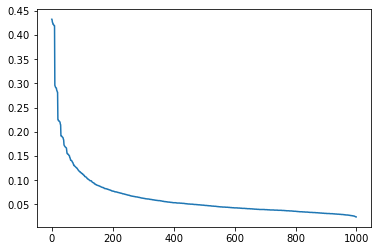

In [5]:
import matplotlib.pyplot as plt

mean_fr = torch.mean(V_gen, 1)

plt.plot(mean_fr[torch.argsort(mean_fr, descending=True)])

In [6]:
from RTRBM.RTRBM_batches import RTRBM

rtrbm3 = RTRBM(V_gen)

In [8]:
N_H = 50
rtrbm3.learn(N_H,
            mean_field = 'False',
            spars_penalty = 3e-5, x = 2, sp = False,
            activationFunction = torch.sigmoid,
            learning_rate = 0.01,  learning_rate_decay = False,
            momentum = 0.9, 
            weightcost = 0.0002, 
            CDk = 10, 
            maxepoch = 200, 
            batchsize = 128,
            disable_tqdm = False)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [3:11:17<00:00, 57.39s/it]


-y-as (nRMSE)errors, x-as sampling rate